In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import seaborn as sns

In [2]:
class Arm:
    def __init__(self, true_mean: float, std: float):
        self.true_mean = true_mean
        self.std = std
        
    def pull(self) -> float:
        return np.random.normal(self.true_mean, self.std)

In [3]:
class MultiArmBandit:
    def __init__(self, arms: List[Arm]):
        self.arms = arms
        self.n_arms = len(arms)
        self.reset()
    
    def reset(self):
        """Reset all tracking variables"""
        self.pulls = np.zeros(self.n_arms)
        self.rewards = np.zeros(self.n_arms)
        self.values = np.zeros(self.n_arms)
        
        # For Thompson Sampling
        self.alpha = np.ones(self.n_arms)
        self.beta = np.ones(self.n_arms)
        
        self.history = {
            'rewards': [],
            'arm_chosen': [],
            'cumulative_reward': 0,
            'regret': []
        }
    
    def pure_exploration(self) -> int:
        """Random arm selection"""
        return np.random.randint(self.n_arms)
    
    def pure_exploitation(self) -> int:
        """Choose the arm with highest empirical mean"""
        means = np.zeros(self.n_arms)
        for i in range(self.n_arms):
            if self.pulls[i] > 0:
                means[i] = self.rewards[i] / self.pulls[i]
            else:
                means[i] = 0
        return np.argmax(means)
    
    def epsilon_greedy(self, epsilon: float) -> int:
        """Epsilon-greedy strategy"""
        if np.random.random() < epsilon:
            return self.pure_exploration()
        else:
            return self.pure_exploitation()
    
    def ucb(self, t: int) -> int:
        """Upper Confidence Bound strategy"""
        ucb_values = np.zeros(self.n_arms)
        
        for i in range(self.n_arms):
            if self.pulls[i] > 0:
                mean_reward = self.rewards[i] / self.pulls[i]
                exploration_bonus = np.sqrt(2 * np.log(t) / self.pulls[i])
                ucb_values[i] = mean_reward + exploration_bonus
            else:
                ucb_values[i] = float('inf')
        
        return np.argmax(ucb_values)
    
    def thompson_sampling(self) -> int:
        """Thompson Sampling strategy"""
        samples = np.random.beta(self.alpha, self.beta)
        return np.argmax(samples)
    
    def update(self, arm_idx: int, reward: float):
        """Update statistics for the chosen arm"""
        self.pulls[arm_idx] += 1
        self.rewards[arm_idx] += reward
        
        # Update Thompson Sampling parameters
        if reward > 0:
            self.alpha[arm_idx] += 1
        else:
            self.beta[arm_idx] += 1
    
    def run_simulation(self, n_rounds: int, strategy: str, epsilon: float = 0.1) -> Dict:
        """Run simulation with specified strategy"""
        self.reset()
        optimal_arm = max(arm.true_mean for arm in self.arms)
        
        for t in range(1, n_rounds + 1):
            # Select arm based on strategy
            if strategy == 'pure_exploration':
                arm_idx = self.pure_exploration()
            elif strategy == 'pure_exploitation':
                arm_idx = self.pure_exploitation()
            elif strategy == 'epsilon_greedy':
                arm_idx = self.epsilon_greedy(epsilon)
            elif strategy == 'ucb':
                arm_idx = self.ucb(t)
            elif strategy == 'thompson':
                arm_idx = self.thompson_sampling()
            else:
                raise ValueError(f"Unknown strategy: {strategy}")
            
            # Pull arm and update statistics
            reward = self.arms[arm_idx].pull()
            self.update(arm_idx, reward)
            
            # Track history
            self.history['rewards'].append(reward)
            self.history['arm_chosen'].append(arm_idx)
            self.history['cumulative_reward'] += reward
            
            # Calculate regret
            regret = optimal_arm - self.arms[arm_idx].true_mean
            self.history['regret'].append(regret)
        
        return self.history

In [4]:
def plot_strategy_comparison(results: Dict[str, Dict], n_arms: int):
    """Plot comparison of different strategies"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot cumulative rewards
    for strategy, history in results.items():
        cumulative_rewards = np.cumsum(history['rewards'])
        ax1.plot(cumulative_rewards, label=strategy)
    
    ax1.set_title('Cumulative Rewards')
    ax1.set_xlabel('Round')
    ax1.set_ylabel('Total Reward')
    ax1.legend()
    
    # Plot cumulative regret
    for strategy, history in results.items():
        cumulative_regret = np.cumsum(history['regret'])
        ax2.plot(cumulative_regret, label=strategy)
    
    ax2.set_title('Cumulative Regret')
    ax2.set_xlabel('Round')
    ax2.set_ylabel('Total Regret')
    ax2.legend()
    
    # Plot arm selection frequencies
    width = 0.15
    x = np.arange(n_arms)
    for i, (strategy, history) in enumerate(results.items()):
        arm_counts = np.bincount(history['arm_chosen'], minlength=n_arms)
        ax3.bar(x + i*width, arm_counts, width, label=strategy)
    
    ax3.set_title('Arm Selection Frequencies')
    ax3.set_xlabel('Arm Index')
    ax3.set_ylabel('Times Selected')
    ax3.legend()
    
    # Plot average rewards over time
    window_size = 100
    for strategy, history in results.items():
        rewards = history['rewards']
        moving_avg = [np.mean(rewards[max(0, i-window_size):i+1]) 
                     for i in range(len(rewards))]
        ax4.plot(moving_avg, label=strategy)
    
    ax4.set_title(f'Moving Average Reward (Window={window_size})')
    ax4.set_xlabel('Round')
    ax4.set_ylabel('Average Reward')
    ax4.legend()
    
    plt.tight_layout()
    return fig

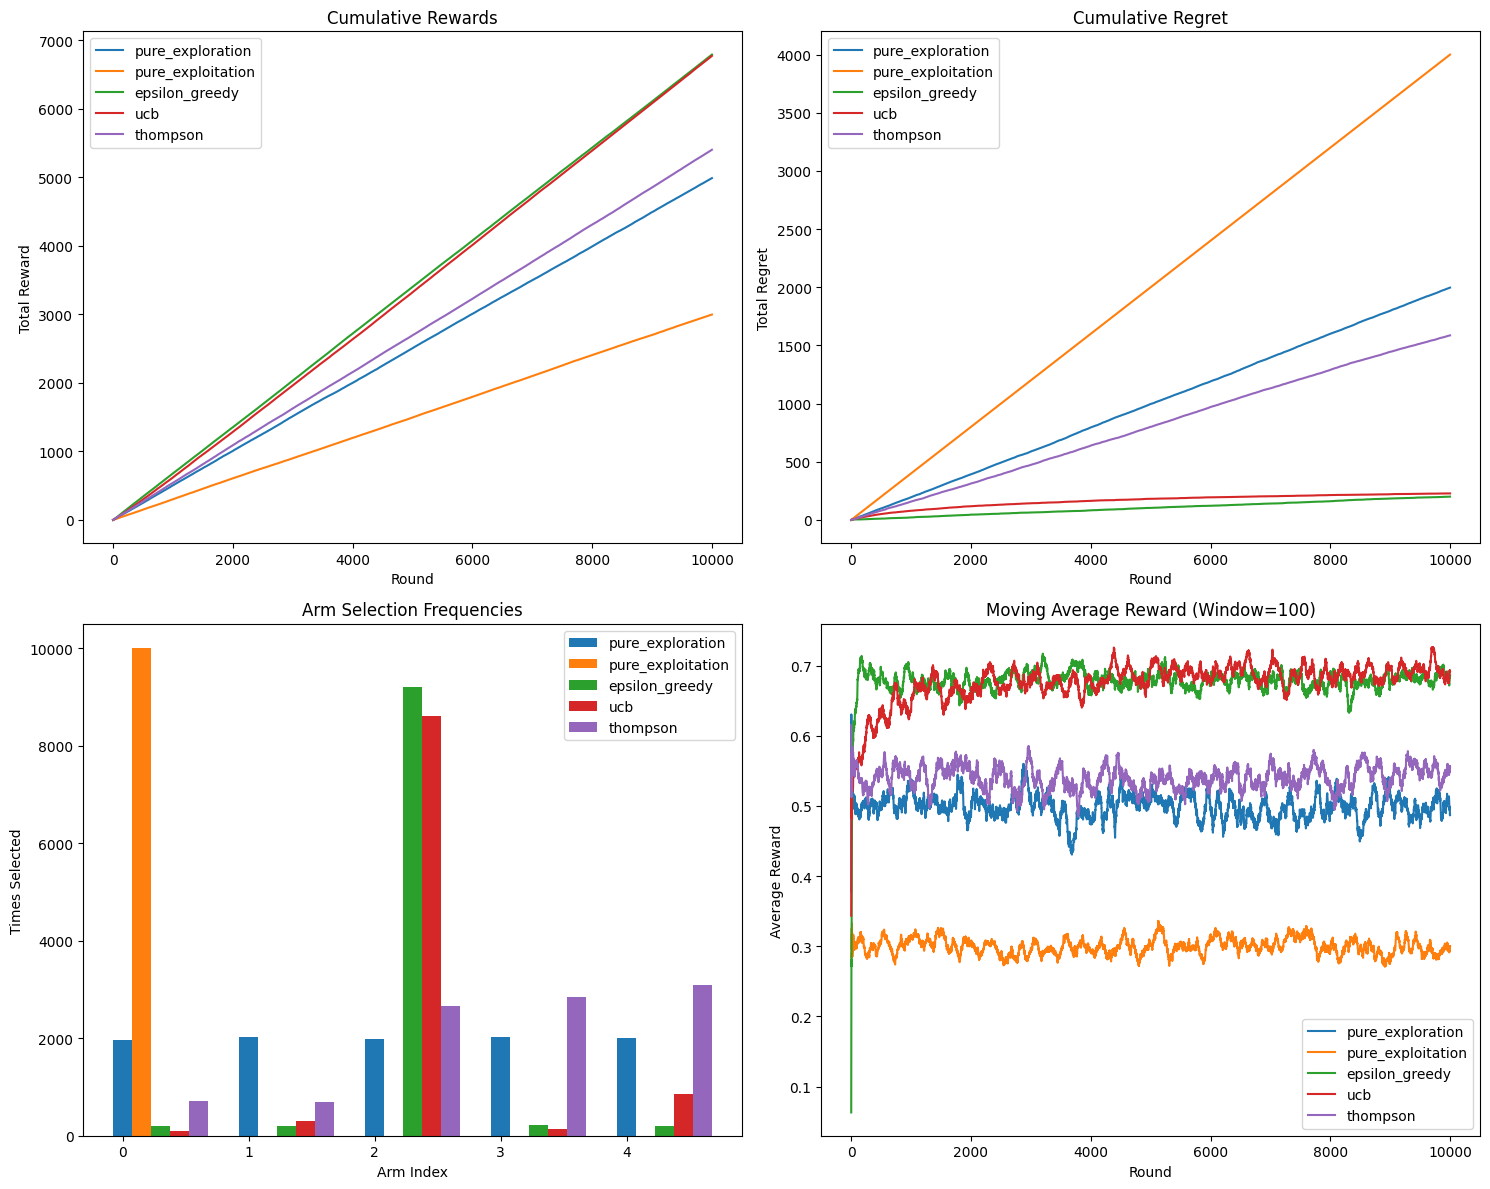


Final Statistics:

PURE_EXPLORATION:
Total Reward: 4989.76
Average Reward: 0.499
Total Regret: 1997.30

PURE_EXPLOITATION:
Total Reward: 2998.33
Average Reward: 0.300
Total Regret: 4000.00

EPSILON_GREEDY:
Total Reward: 6792.72
Average Reward: 0.679
Total Regret: 200.70

UCB:
Total Reward: 6774.21
Average Reward: 0.677
Total Regret: 228.10

THOMPSON:
Total Reward: 5404.06
Average Reward: 0.540
Total Regret: 1586.50


In [5]:
# Create arms with different reward distributions
arms = [
    Arm(true_mean=0.3, std=0.1),
    Arm(true_mean=0.5, std=0.1),
    Arm(true_mean=0.7, std=0.1),
    Arm(true_mean=0.4, std=0.1),
    Arm(true_mean=0.6, std=0.1)
]

# Initialize MAB
mab = MultiArmBandit(arms)

# Run simulations for each strategy
n_rounds = 10000
results = {}

strategies = {
    'pure_exploration': {},
    'pure_exploitation': {},
    'epsilon_greedy': {'epsilon': 0.1},
    'ucb': {},
    'thompson': {}
}

for strategy, params in strategies.items():
    results[strategy] = mab.run_simulation(n_rounds, strategy, **params)

# Plot results
plot_strategy_comparison(results, len(arms))
plt.show()

# Print final statistics
print("\nFinal Statistics:")
for strategy, history in results.items():
    print(f"\n{strategy.upper()}:")
    print(f"Total Reward: {history['cumulative_reward']:.2f}")
    print(f"Average Reward: {history['cumulative_reward']/n_rounds:.3f}")
    print(f"Total Regret: {sum(history['regret']):.2f}")